Create spark session

In [94]:
import sys, glob, os
SPARK_HOME = "/Users/abulbasar/Downloads/spark-2.3.1-bin-hadoop2.7"
sys.path.append(SPARK_HOME + "/python")
sys.path.append(glob.glob(SPARK_HOME + "/python/lib/py4j*.zip")[0])
from pyspark.sql import SparkSession, functions as F
spark = (SparkSession
         .builder
         .config("spark.master", "local[*]")
         .config("spark.driver.memory", "4G")
         .config("spark.sql.shuffle.partitions", 16)
         .getOrCreate())
sc = spark.sparkContext
print(sc.uiWebUrl)
sql = spark.sql

http://10.150.236.40:4040


Create utility function to load data into a spark dataframe

In [95]:
import re
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline 

base_dir = "/data/movielens/"

def cache_df(df, name):
    df.createOrReplaceTempView(name)
    spark.catalog.cacheTable(name)
    
def load(file):
    name = re.sub("[^A-Za-z0-9]", "_", file[:-4])
    df = spark.read.option("header", True).option("inferSchema", True).csv(base_dir + file)
    cache_df(df, name)
    df.alias(name)
    return df

Load data

In [96]:
movies = load("movies.csv")
ratings = load("ratings.csv")

sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        | df_train|       true|
|        |   movies|       true|
|        |  ratings|       true|
+--------+---------+-----------+



Take a look at movies dataset. It shows by default first 20 records.

In [97]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

View the ratings data.

In [98]:
ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



How many rating levels are there? Find count by each rating level

In [99]:
ratings.groupBy("rating").count().toPandas().sort_values("rating")

,rating,count
4,0.5,1101
1,1.0,3326
2,1.5,1687
9,2.0,7271
0,2.5,4449
8,3.0,20064
6,3.5,10538
5,4.0,28750
7,4.5,7723
3,5.0,15095


Find top 10 movies based on the highest avg rating. Each top movies must have at least 100 ratings to make the avg to reliable.

In [124]:
top10 = (ratings
 .groupBy("movieId")
 .agg(F.avg("rating").alias("avg_rating"), F.count("*").alias("rating_count"))
 .filter("rating_count > 100")
 .join(movies, on = "movieId")
 .select("movieId", "avg_rating", "title")
 .orderBy(F.desc("avg_rating"))
 .limit(10)
)
top10.show()

+-------+------------------+--------------------+
|movieId|        avg_rating|               title|
+-------+------------------+--------------------+
|    318| 4.405144694533762|Shawshank Redempt...|
|    858|             4.395|Godfather, The (1...|
|   1221| 4.303703703703704|Godfather: Part I...|
|     50|4.2835820895522385|Usual Suspects, T...|
|    527| 4.209016393442623|Schindler's List ...|
|    608| 4.191964285714286|        Fargo (1996)|
|    912| 4.162393162393163|   Casablanca (1942)|
|    296| 4.157407407407407| Pulp Fiction (1994)|
|   1193| 4.138888888888889|One Flew Over the...|
|   1196| 4.136752136752137|Star Wars: Episod...|
+-------+------------------+--------------------+



Does the rating pattern changes from user to user? For example, one user tends to give higher rating than other? Let's take a look at top 100 most rated movies, and group rating by users to find their median rating

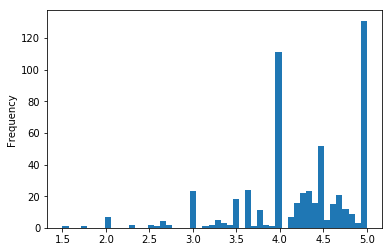

In [131]:
(ratings
 .join(top10, on = "movieId")
 .groupBy("userId")
 .agg(F.avg("rating").alias("avg_rating"))
).toPandas()["avg_rating"].plot.hist(bins = 50)

We notice event for the that can be considered good movies in generated has a wide range of perception among the viewers.

Change the fraction rating values to intger to reduce the number of rating.

In [100]:
ratings = ratings.withColumn("rating", F.expr("cast(rating as int)"))
ratings.groupBy("rating").count().toPandas().sort_values("rating")

,rating,count
5,0,1101
2,1,5013
3,2,11720
1,3,30602
4,4,36473
0,5,15095


Find the distribution of rating by plotting histogram.

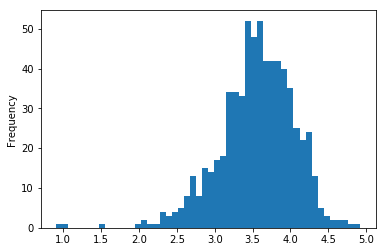

In [101]:
ratings.groupBy("userId").agg(F.avg("rating").alias("avg_rating")).toPandas().avg_rating.plot.hist(bins = 50)

How the average rating have changed over years.

Text(0,0.5,'Avg Rating')

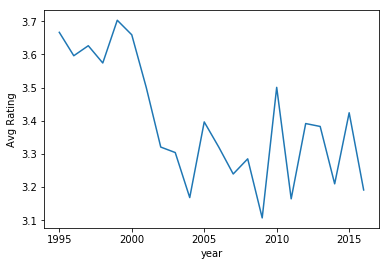

In [102]:
avg_rating_by_year = (ratings
 .withColumn("year", F.expr("year(from_unixtime(timestamp))"))
 .groupBy("year")
 .agg(F.avg("rating").alias("avg_rating"))
).toPandas()

avg_rating_by_year = avg_rating_by_year.sort_values("year")
avg_rating_by_year.index = avg_rating_by_year.year

avg_rating_by_year.avg_rating.plot()

plt.ylabel("Avg Rating")

Find number of unique users.

In [103]:
ratings.selectExpr("count(distinct userId)").first()

Row(count(DISTINCT userId)=671)

Find number of unique movieIds.

In [104]:
ratings.selectExpr("count(distinct movieId)").first()

Row(count(DISTINCT movieId)=9066)

Does all the movie id mentioned in rating present in the movies table as well? Expected count from the statement below should be 0, if all values are present. 

In [105]:
ratings.join(movies, on = ["movieId"], how = "leftanti").show()

+-------+------+------+---------+
|movieId|userId|rating|timestamp|
+-------+------+------+---------+
+-------+------+------+---------+



What is distribution of the number of rating by each movie

In [106]:
ratings.groupBy("movieId").count().select("count").describe().show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|              9066|
|   mean|11.030664019413193|
| stddev|24.050799967665892|
|    min|                 1|
|    max|               341|
+-------+------------------+



Find the average rating by each user and rating count.

In [107]:
avg_rating = ratings.groupBy("userId").agg(F.count("*").alias("count"), F.avg("rating").alias("avg_rating"))
avg_rating.show()

+------+-----+------------------+
|userId|count|        avg_rating|
+------+-----+------------------+
|    12|   61|2.7540983606557377|
|    18|   51| 3.235294117647059|
|    38|  111| 4.045045045045045|
|    67|  103|3.7572815533980584|
|    70|   83| 4.204819277108434|
|    93|  159|3.5723270440251573|
|   161|   90| 3.588888888888889|
|   186|   42|3.5952380952380953|
|   190|   60|               4.0|
|   218|   42|3.6904761904761907|
|   225|   28| 4.107142857142857|
|   257|  103| 3.378640776699029|
|   261|   50|              3.44|
|   263|  114| 3.043859649122807|
|   273|   92| 4.119565217391305|
|   275|  202| 4.262376237623762|
|   280|   22| 4.318181818181818|
|   295|  236|  3.73728813559322|
|   300|   44|3.8181818181818183|
|   317|   22|               3.5|
+------+-----+------------------+
only showing top 20 rows



Which movies are more consistent rating from users. We can take standard deviation as measure of consistency. 

In [108]:
(ratings
 .groupBy("movieId")
 .agg(F.avg("rating")
       , F.stddev("rating").alias("std")
       , F.count("*").alias("count"))
 .filter("not isnan(std)")
 .orderBy(F.desc("std"))
).show()

+-------+-----------+------------------+-----+
|movieId|avg(rating)|               std|count|
+-------+-----------+------------------+-----+
|   2483|        2.5|3.5355339059327378|    2|
|  27178|        2.5|3.5355339059327378|    2|
|   6219|        2.5|3.5355339059327378|    2|
|  75341|        2.0|2.8284271247461903|    2|
|   7577|        2.0|2.8284271247461903|    2|
|  98122|        2.0|2.8284271247461903|    2|
|   4562|        3.0|2.8284271247461903|    2|
|   4404|        3.0|2.8284271247461903|    2|
|  31364|        2.0|2.8284271247461903|    2|
|   3415|        3.0|2.8284271247461903|    2|
|   2824|        3.0|2.8284271247461903|    2|
|  66246|        2.0|2.8284271247461903|    2|
|   6127|        2.0|2.8284271247461903|    2|
|   3490|        3.0|2.8284271247461903|    2|
|   3892|        3.0|2.8284271247461903|    2|
| 135436|        3.0|2.8284271247461903|    2|
|   4630|        3.0|2.8284271247461903|    2|
|   5179|        3.0|2.8284271247461903|    2|
|  95199|    

Devide the dataset into training and test

In [16]:
df_train, df_test = (ratings.randomSplit([0.7, 0.3], seed = 1))
cache_df(df_train, "df_train")

Apply matrix factorization using ALS (alternate least square) from mllib

In [17]:
from pyspark.ml.recommendation import ALS

In [109]:
als = ALS(rank=10, maxIter=5, seed=0,
          userCol= "userId", itemCol= "movieId", ratingCol="rating")
als_model = als.fit(df_train)

View the iterm factors. These factors are found by ALS model. These represent latent properties of the each movie. Rank or the dimension is 10 as we specied in the ALS model.

In [19]:
als_model.itemFactors.limit(10).toPandas()

,id,features
0,10,"[-0.6119903326034546, 0.2717360258102417, 0.08..."
1,20,"[-0.5250846743583679, 0.8127381205558777, 0.32..."
2,30,"[-1.2488008737564087, 0.31565776467323303, -0...."
3,40,"[-0.4015123248100281, -0.24699324369430542, -0..."
4,50,"[-0.9165343046188354, -0.3675995469093323, -0...."
5,60,"[-0.85568767786026, 0.21060891449451447, 0.085..."
6,70,"[-0.7626186013221741, -0.6614616513252258, -0...."
7,80,"[-1.188989520072937, -0.6905847787857056, -1.0..."
8,100,"[-1.0212198495864868, 0.11593789607286453, 0.4..."
9,110,"[-0.6032668948173523, -0.10099033266305923, -0..."


Find all the movies by userId = 100. It is just example user.

In [20]:
ratings.filter("userId = 100").join(movies, 
            on = "movieId").orderBy(F.desc("rating")).show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|     32|   100|     5|854193977|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|   1073|   100|     5|854194056|Willy Wonka & the...|Children|Comedy|F...|
|      3|   100|     4|854194024|Grumpier Old Men ...|      Comedy|Romance|
|    608|   100|     4|854194024|        Fargo (1996)|Comedy|Crime|Dram...|
|    745|   100|     4|854194208|Wallace & Gromit:...|Animation|Childre...|
|    802|   100|     4|854194111|   Phenomenon (1996)|       Drama|Romance|
|   1356|   100|     4|854194086|Star Trek: First ...|Action|Adventure|...|
|     25|   100|     4|854193977|Leaving Las Vegas...|       Drama|Romance|
|      1|   100|     4|854193977|    Toy Story (1995)|Adventure|Animati...|
|      6|   100|     3|854194023|         Heat (1995)|Action|Crime|Thri...|
|      7|   

### Item to item similarity

We see movieId = 32 has been one the top rated movie for user = 100. Find out movies similar to this movie = 32. For similarity consine similarity has been used on the iterm vectors. 

In [68]:
from pyspark.sql.types import DoubleType
import numpy as np
import scipy
import scipy.spatial

def distance(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return float(scipy.spatial.distance.cosine(v1, v2))

spark.udf.register("distance", distance, DoubleType())

def recommendation_by_i2i(movie_id):
    return (als_model
     .itemFactors
     .filter(F.col("id") == movie_id)
     .alias("t1")
     .crossJoin(als_model.itemFactors.alias("t2"))
     .withColumn("similarity", F.expr("distance(t1.features, t2.features)")) 
     .join(movies, F.col("t2.id") == F.col("movieId"))
     .orderBy(F.asc("similarity"))
     .select("movieId", "title", "similarity")
    )

recommendation_by_i2i(32).show(10, False)

+-------+-------------------------------------------------------------------------+--------------------+
|movieId|title                                                                    |similarity          |
+-------+-------------------------------------------------------------------------+--------------------+
|32     |Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                                |0.0                 |
|46322  |Jet Li's Fearless (Huo Yuan Jia) (2006)                                  |0.008989705001690163|
|2275   |Six-String Samurai (1998)                                                |0.010203252621868497|
|2502   |Office Space (1999)                                                      |0.010878541752999515|
|49957  |History Boys, The (2006)                                                 |0.014252301792101796|
|62344  |Rachel Getting Married (2008)                                            |0.01599857601792687 |
|76077  |Hot Tub Time Machine (2010)                   

In [71]:
recommendation_by_i2i(10).show(10, False) # movieId for GoldenEye (1995) is 10 

+-------+---------------------------------------------+--------------------+
|movieId|title                                        |similarity          |
+-------+---------------------------------------------+--------------------+
|10     |GoldenEye (1995)                             |0.0                 |
|3249   |Hand That Rocks the Cradle, The (1992)       |0.019739230609736924|
|2406   |Romancing the Stone (1984)                   |0.02105859648238928 |
|454    |Firm, The (1993)                             |0.021639110689007923|
|1393   |Jerry Maguire (1996)                         |0.023246487402172167|
|733    |Rock, The (1996)                             |0.023711253436034863|
|2      |Jumanji (1995)                               |0.025654501255907514|
|867    |Carpool (1996)                               |0.02693095927125455 |
|747    |Stupids, The (1996)                          |0.027019454687792543|
|103235 |Best Offer, The (Migliore offerta, La) (2013)|0.02740922637162979 |

Like item Factors we can see the user factors representing the latent propeties of the user.

In [72]:
als_model.userFactors.limit(10).toPandas()

,id,features
0,10,"[-0.27867308259010315, 0.5459980964660645, -0...."
1,20,"[-0.9683108925819397, 0.06215322017669678, 0.1..."
2,30,"[-0.4050779938697815, 0.39974474906921387, -0...."
3,40,"[-0.3554266691207886, -0.3823551535606384, -0...."
4,50,"[-0.5981726050376892, 0.3503716289997101, 0.10..."
5,60,"[-0.266533762216568, -0.4195394814014435, -0.5..."
6,70,"[-0.8268013000488281, 0.2105957567691803, 0.26..."
7,80,"[-0.7081996202468872, -0.46596139669418335, -0..."
8,90,"[-0.5121882557868958, -0.030749192461371422, 0..."
9,100,"[-0.65791916847229, 0.05630388855934143, -0.17..."


### User to User similarity

Find top movies by user; assume, the top movies are those that the user has rated 4 or 5. 

In [82]:
top_rated_movies_by_user = (ratings
                            .filter("rating = 4 or rating = 5")
                            .groupBy("userId")
                            .agg(F.collect_set("movieId").alias("top_movies")))
top_rated_movies_by_user.show()

+------+--------------------+
|userId|          top_movies|
+------+--------------------+
|    12|[1220, 1235, 3798...|
|    18|[785, 17, 32, 786...|
|    38|[110, 356, 8197, ...|
|    67|[610, 356, 589, 1...|
|    70|[81, 52, 785, 25,...|
|    93|[44195, 1097, 499...|
|   161|[161, 356, 589, 5...|
|   186|[4306, 4226, 4873...|
|   190|[2716, 2390, 2585...|
|   218|[2186, 4226, 1200...|
|   225|[356, 589, 153, 5...|
|   257|[3000, 1222, 3080...|
|   261|[356, 589, 590, 7...|
|   263|[356, 2803, 590, ...|
|   273|[31696, 8874, 441...|
|   275|[356, 3450, 71579...|
|   280|[1917, 17, 2006, ...|
|   295|[466, 356, 364, 4...|
|   300|[110, 356, 589, 1...|
|   317|[356, 150, 165, 3...|
+------+--------------------+
only showing top 20 rows



In [91]:
def recommendation_by_u2u(user_id):
    return (als_model
     .userFactors
     .filter(F.col("id") == user_id)
     .alias("t1")
     .crossJoin(als_model.itemFactors.alias("t2"))
     .withColumn("similarity", F.expr("distance(t1.features, t2.features)"))
     .filter("similarity < 0.03") # 0.02 Similarity threshold - a hyper parameter. We can perform tuning to find the suitable value
     .join(top_rated_movies_by_user.alias("t3"), F.col("t2.id") == F.col("t3.userId"))
     .select("t1.id", F.explode("top_movies").alias("movieId"))
     .join(movies, on = "movieId")
     .select("movieId", "title")
    )

recommendation_by_u2u(100).show(10, False)

+-------+--------------------------------------+
|movieId|title                                 |
+-------+--------------------------------------+
|589    |Terminator 2: Judgment Day (1991)     |
|4995   |Beautiful Mind, A (2001)              |
|70286  |District 9 (2009)                     |
|6440   |Barton Fink (1991)                    |
|4822   |Max Keeble's Big Move (2001)          |
|1222   |Full Metal Jacket (1987)              |
|3421   |Animal House (1978)                   |
|1193   |One Flew Over the Cuckoo's Nest (1975)|
|48780  |Prestige, The (2006)                  |
|608    |Fargo (1996)                          |
+-------+--------------------------------------+
only showing top 10 rows



In [134]:
(ratings
 .join(movies, on = "movieId")
 .filter("userId = 100")
 .orderBy(F.desc("rating"))
).show()

+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|     32|   100|     5|854193977|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|   1073|   100|     5|854194056|Willy Wonka & the...|Children|Comedy|F...|
|      3|   100|     4|854194024|Grumpier Old Men ...|      Comedy|Romance|
|    608|   100|     4|854194024|        Fargo (1996)|Comedy|Crime|Dram...|
|    745|   100|     4|854194208|Wallace & Gromit:...|Animation|Childre...|
|    802|   100|     4|854194111|   Phenomenon (1996)|       Drama|Romance|
|   1356|   100|     4|854194086|Star Trek: First ...|Action|Adventure|...|
|     25|   100|     4|854193977|Leaving Las Vegas...|       Drama|Romance|
|      1|   100|     4|854193977|    Toy Story (1995)|Adventure|Animati...|
|      6|   100|     3|854194023|         Heat (1995)|Action|Crime|Thri...|
|      7|   

Let's see what results the simiarity match between the user factors and movies factors give.

In [153]:
def recommendation_by_u2i(userId):
    return (als_model
     .userFactors.alias("t1")
     .filter(F.col("id") == userId)
     .crossJoin(als_model.itemFactors.alias("t2"))
     .withColumn("similarity", F.expr("distance(t1.features, t2.features)"))
     .orderBy(F.asc("similarity"))
     .join(movies, F.col("t2.id") == F.col("movieId"))
     .select("similarity", "title")
     .limit(20)
    )
recommendation_by_u2i(100).show(20, False)

+--------------------+----------------------------------------------+
|similarity          |title                                         |
+--------------------+----------------------------------------------+
|0.02291440172371373 |Mary Poppins (1964)                           |
|0.033117143234550506|Bus 174 (Ônibus 174) (2002)                   |
|0.03588223110136224 |Fantastic Mr. Fox (2009)                      |
|0.04020801883324454 |Christmas Story, A (1983)                     |
|0.04325626207399513 |Drop Dead Gorgeous (1999)                     |
|0.044425947834241364|Once (2006)                                   |
|0.0445282917289207  |Manon of the Spring (Manon des sources) (1986)|
|0.04523102711801197 |Elizabeth (1998)                              |
|0.04547643759010589 |Tom Jones (1963)                              |
|0.04608449690531313 |Others, The (2001)                            |
|0.047883872328780996|Lord of the Rings, The (1978)                 |
|0.04878641590219101

Predict the rating for each movie and user combination in the df_test dataset.

In [23]:
df_prediction = als_model.transform(df_test)
df_prediction.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   157|     12|     2|1291598164| 2.2820864|
|   564|     12|     1| 974709821| 3.0669582|
|    91|     12|     3|1448813887| 3.8011193|
|   624|     12|     2|1019563753| 2.0999196|
|   636|     18|     3| 855227364| 3.5984566|
|   616|     18|     4| 860573132| 3.3177824|
|   571|     18|     5|1334342436| 2.6853292|
|   135|     18|     4| 844996129| 3.0119503|
|   255|     18|     2|1236980522|   2.22563|
|   461|     18|     1|1091959887| 2.5870395|
|   408|     18|     5| 933116210| 2.7201877|
|   507|     18|     4| 862091839| 3.9740381|
|   177|     18|     4| 907380994| 3.8975425|
|    30|     18|     2| 945277971|   3.56654|
|   655|     18|     4|1470073389| 3.5001454|
|   165|     70|     5|1111480089| 2.4006498|
|   358|     70|     1| 957534713| 2.4248333|
|    34|     70|     4| 973746231| 3.1537461|
|   580|     70|     2|1165292373|

Find predictions of rating for user 575 and compare it against the actual rating. 

In [24]:
df_prediction.filter("userId = 575").show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    613|     4|1012594056| 3.0942912|
|   575|    912|     5|1012593307| 3.9532857|
|   575|   1256|     5|1012595762| 3.5967388|
|   575|   1479|     2|1012594286| 2.6165662|
|   575|   1943|     3|1012606205|  2.818478|
|   575|   2716|     5|1012593003| 3.3207188|
|   575|   2728|     3|1012604429| 3.7774029|
|   575|   2968|     5|1012597696|   3.29526|
|   575|   3196|     4|1012604409|  3.940699|
|   575|   3516|     3|1018056630| 1.8980706|
|   575|   5232|     4|1018058258|       NaN|
|   575|    539|     3|1012593690| 3.1185648|
|   575|    913|     5|1012593062| 3.9654267|
|   575|   1022|     4|1012594848| 3.2438915|
|   575|   1597|     4|1012594028| 2.3618226|
|   575|   2099|     3|1012594848| 4.1307707|
|   575|   3244|     4|1012596068| 3.0916982|
|   575|   3421|     3|1012595812| 3.5597823|
|   575|   5034|     5|1012593616|

For for some movie prediction is nan. Likely, those movies do not have any records in the df_train.

In [25]:
df_prediction.filter("isnan(prediction)").orderBy("movieId").show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   514|     83|     3| 853893246|       NaN|
|   311|     83|     3| 898008016|       NaN|
|   383|     83|     3| 852809207|       NaN|
|   564|    108|     4| 974713920|       NaN|
|   555|    114|     3| 857379668|       NaN|
|   452|    119|     3| 976423036|       NaN|
|    86|    124|     3| 848161391|       NaN|
|   665|    129|     3| 995232528|       NaN|
|    41|    130|     4|1093889645|       NaN|
|   575|    148|     4|1012605106|       NaN|
|   564|    184|     5| 974715756|       NaN|
|   254|    184|     4| 845158097|       NaN|
|   312|    187|     3| 959930966|       NaN|
|   439|    187|     2|1041115023|       NaN|
|   393|    187|     3|1058472448|       NaN|
|   564|    189|     4| 974838288|       NaN|
|   182|    243|     4| 845745917|       NaN|
|   647|    245|     3| 947292322|       NaN|
|   516|    251|     3| 844687985|

In [26]:
df_prediction.filter("movieId = 148").show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    148|     4|1012605106|       NaN|
+------+-------+------+----------+----------+



In [27]:
df_train.filter("movieId = 148").show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
+------+-------+------+---------+



In [28]:
als_model.itemFactors.filter("id = 148").show()

+---+--------+
| id|features|
+---+--------+
+---+--------+



In [29]:
recommendations_by_user = als_model.recommendForAllUsers(10)
recommendations_by_user.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|    70|[[3153, 6.0009284...|
|   190|[[67504, 6.059529...|
|   280|[[83318, 5.807171...|
|   300|[[59684, 5.281603...|
|   340|[[121231, 5.42872...|
|   600|[[121231, 5.47754...|
|   640|[[5114, 5.328731]...|
|   660|[[8530, 5.2560177...|
|   161|[[4799, 5.131041]...|
|   261|[[8530, 5.838298]...|
|   471|[[8530, 4.791874]...|
|   581|[[149, 4.6003914]...|
|   611|[[121231, 5.71576...|
|   641|[[6413, 5.652473]...|
|    12|[[4467, 5.6054363...|
|   412|[[6413, 5.442573]...|
|   452|[[83359, 4.945468...|
|   612|[[5114, 4.84929],...|
|   662|[[6413, 5.068833]...|
|    93|[[83411, 4.972806...|
+------+--------------------+
only showing top 20 rows



Display the list of movie recommended for the users. If you are interested to see the recommendation for a given user, you can filter the result by userId.

In [30]:
recommendations_by_user_enriched = (recommendations_by_user
.withColumn("recommendation", F.explode("recommendations"))
.withColumn("movieId", F.expr("recommendation.movieId"))
.withColumn("recommended_rating", F.expr("recommendation.rating"))
.drop("recommendations")
.drop("recommendation")
.join(movies, on = "movieId")
)

recommendations_by_user_enriched.show()

+-------+------+------------------+--------------------+--------------------+
|movieId|userId|recommended_rating|               title|              genres|
+-------+------+------------------+--------------------+--------------------+
|   3153|    70|         6.0009284|7th Voyage of Sin...|Action|Adventure|...|
|  26152|    70|          5.956971|       Batman (1966)|Action|Adventure|...|
|  83318|    70|         5.9138904|    Goat, The (1921)|              Comedy|
|  67504|    70|         5.9138904|Land of Silence a...|         Documentary|
|  83411|    70|         5.9138904|         Cops (1922)|              Comedy|
|  83359|    70|         5.9138904|Play House, The (...|              Comedy|
|   6375|    70|         5.8239217|Gigantic (A Tale ...|         Documentary|
|   8580|    70|         5.7976513|Into the Woods (1...|Adventure|Comedy|...|
|   2920|    70|          5.790113|Children of Parad...|       Drama|Romance|
|   1564|    70|         5.7485266|For Roseanna (Ros...|Comedy|D

In [31]:
recommendations_by_user_enriched.filter("userId = 547").show()

+-------+------+------------------+--------------------+-----------------+
|movieId|userId|recommended_rating|               title|           genres|
+-------+------+------------------+--------------------+-----------------+
|  67504|   547|          5.305828|Land of Silence a...|      Documentary|
|  83411|   547|          5.305828|         Cops (1922)|           Comedy|
|  83318|   547|          5.305828|    Goat, The (1921)|           Comedy|
|  83359|   547|          5.305828|Play House, The (...|           Comedy|
|  96075|   547|          5.024853|  Bleak House (2005)|            Drama|
|   8123|   547|          5.024853|Sammy and Rosie G...|     Comedy|Drama|
|   8261|   547|          5.024853|3 Women (Three Wo...|            Drama|
| 101850|   547|          5.024853|Death on the Stai...|Crime|Documentary|
| 150856|   547|          5.024853|Making a Murderer...|      Documentary|
|  26501|   547|          5.024853|    Choose Me (1984)|   Comedy|Romance|
+-------+------+---------

Find most active users, their avg rating and rating standard deviation. We like to see how the list of highly rated (4 or 5 rating) matches up with the recommendation.

In [32]:
rating_count_by_user = (ratings
 .groupBy("userId")
 .agg(F.avg("rating").alias("avg_rating")
      , F.count("*").alias("rating_count")
      , F.stddev("rating").alias("std_rating")
     )
 .orderBy(F.desc("rating_count"))
)

rating_count_by_user.show()

+------+------------------+------------+------------------+
|userId|        avg_rating|rating_count|        std_rating|
+------+------------------+------------+------------------+
|   547|  3.18025930572982|        2391|1.1206147892804919|
|   564|3.5524625267665955|        1868|1.1718577106638184|
|   624| 2.752737752161383|        1735|1.0923146898170415|
|    15| 2.458823529411765|        1700|1.3042506789210637|
|    73| 3.129192546583851|        1610|0.9950555044812739|
|   452| 3.102238805970149|        1340|1.0467037358614122|
|   468|2.7064291247095276|        1291| 0.830492820099226|
|   380| 3.226716839134525|        1063|0.9399890019033345|
|   311| 2.815505397448479|        1019|0.9367601938732544|
|    30|3.7636003956478734|        1011|0.9262404017005623|
|   294|3.3875395987328405|         947| 0.671665255069752|
|   509| 3.293607800650054|         923|0.9299967846980056|
|   580| 3.049891540130152|         922|0.8565421667014946|
|   213|2.4186813186813185|         910|

In [33]:
rating_count_by_user.selectExpr("mean(std_rating)").first()

Row(avg(std_rating)=0.9717669109338198)

Plot the distribution (hist) of the number of ratings by users.

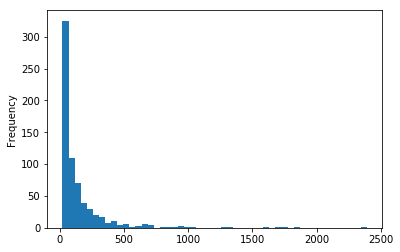

In [34]:
rating_count_by_user.select("rating_count").toPandas()["rating_count"].plot.hist(bins = 50)

See movie recommendations for a given user. See the recommendations for one of most active users.

In [35]:
def reco_for_user(userId): 
    return (
            als_model
             .recommendForUserSubset(df_train.filter(F.col("userId") == userId), 500)
             .withColumn("recommendation", F.explode("recommendations"))
             .withColumn("movieId", F.expr("recommendation.movieId"))
             .withColumn("recommended_rating", F.expr("recommendation.rating"))
             .drop("recommendations")
             .drop("recommendation")
             .join(ratings.filter(F.col("userId") == userId), on = "movieId", how = "leftanti")
             .join(movies, on = "movieId")
             .orderBy(F.desc("recommended_rating"))
            )
reco_for_user(547).show()

+-------+------+------------------+--------------------+--------------------+
|movieId|userId|recommended_rating|               title|              genres|
+-------+------+------------------+--------------------+--------------------+
|  83318|   547|          5.305828|    Goat, The (1921)|              Comedy|
|  83359|   547|          5.305828|Play House, The (...|              Comedy|
|  67504|   547|          5.305828|Land of Silence a...|         Documentary|
|  83411|   547|          5.305828|         Cops (1922)|              Comedy|
|   1180|   547|         4.5169625| Hear My Song (1991)|              Comedy|
|  86504|   547|          4.419376|Voices from the L...|         Documentary|
|   8751|   547|         4.3445444|Gun Crazy (a.k.a....|Crime|Drama|Film-...|
|   4427|   547|         4.2814674|Lion in Winter, T...|               Drama|
|  56715|   547|          4.275058|Wristcutters: A L...|Drama|Fantasy|Rom...|
|   6918|   547|         4.2680645|Unvanquished, The...|        

Find a few users who have moderate number of ratings.

In [36]:
rating_count_by_user.filter("rating_count = 25").show()

+------+----------+------------+------------------+
|userId|avg_rating|rating_count|        std_rating|
+------+----------+------------+------------------+
|   637|      3.96|          25|1.0198039027185568|
|   331|      3.48|          25|1.2948616399703357|
|   375|      3.56|          25| 1.260952021291849|
|   377|      3.12|          25|0.9273618495495702|
|    44|      3.36|          25|0.8602325267042625|
|   114|      4.08|          25|1.0376254944182253|
|   100|       3.4|          25|0.7071067811865476|
|   269|       3.4|          25|1.0801234497346432|
|   446|      4.44|          25|0.5066228051190221|
|   556|       4.4|          25|0.7637626158259734|
|   538|       3.6|          25|1.0408329997330665|
|   392|      2.92|          25|1.1150485789118487|
|   116|       3.8|          25| 1.384437310486346|
|   495|      4.08|          25|0.7593857166596345|
+------+----------+------------+------------------+



In [37]:
reco_for_user(100).show()

+-------+------+------------------+--------------------+--------------------+
|movieId|userId|recommended_rating|               title|              genres|
+-------+------+------------------+--------------------+--------------------+
|  83318|   100|          5.399297|    Goat, The (1921)|              Comedy|
|  83359|   100|          5.399297|Play House, The (...|              Comedy|
|  67504|   100|          5.399297|Land of Silence a...|         Documentary|
|  83411|   100|          5.399297|         Cops (1922)|              Comedy|
|   5114|   100|         5.2913103|Bad and the Beaut...|               Drama|
|   2202|   100|         4.9161224|     Lifeboat (1944)|           Drama|War|
|   7087|   100|         4.9139767|Passage to India,...|     Adventure|Drama|
|   3989|   100|         4.8830647|One Day in Septem...|         Documentary|
|   2920|   100|         4.8446193|Children of Parad...|       Drama|Romance|
|   8264|   100|         4.8080645| Grey Gardens (1975)|        

### Evaluate the recommendations

One more let's see the recommendations for the user movie combination in the df_test dataset.

In [38]:
als_model.transform(df_test).show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   157|     12|     2|1291598164| 2.2820864|
|   564|     12|     1| 974709821| 3.0669582|
|    91|     12|     3|1448813887| 3.8011193|
|   624|     12|     2|1019563753| 2.0999196|
|   636|     18|     3| 855227364| 3.5984566|
|   616|     18|     4| 860573132| 3.3177824|
|   571|     18|     5|1334342436| 2.6853292|
|   135|     18|     4| 844996129| 3.0119503|
|   255|     18|     2|1236980522|   2.22563|
|   461|     18|     1|1091959887| 2.5870395|
|   408|     18|     5| 933116210| 2.7201877|
|   507|     18|     4| 862091839| 3.9740381|
|   177|     18|     4| 907380994| 3.8975425|
|    30|     18|     2| 945277971|   3.56654|
|   655|     18|     4|1470073389| 3.5001454|
|   165|     70|     5|1111480089| 2.4006498|
|   358|     70|     1| 957534713| 2.4248333|
|    34|     70|     4| 973746231| 3.1537461|
|   580|     70|     2|1165292373|

Find root mean squared error based on the df_test

In [39]:
(als_model
.transform(df_test)
.filter("not isnan(prediction)")
.selectExpr("sqrt(avg(pow((rating - prediction), 2))) test_rmse")
).show()

+------------------+
|         test_rmse|
+------------------+
|0.9751612132040609|
+------------------+



Find the rmse for the training data. It is expected, the rmse for the training dataset would be better than the test dataset. Lower the value of RMSE, better it is.

In [40]:
(als_model
.transform(df_train)
.filter("not isnan(prediction)")
.selectExpr("sqrt(avg(pow((rating - prediction), 2))) train_rmse")
).show()

+------------------+
|        train_rmse|
+------------------+
|0.5988259423059014|
+------------------+



# Classification Models for recommendations

Idea is that based on the features of movies and users, can we estimated what will be the rating. 

Example of features of the movies 
- year of release
- number users who have rated high (4 or 5)
- number of ratings (usually for these of high magnitude, take a log of the count)
- associated genre 
- genre properties such as number avg rating by the genre.

Features by users 
- how many movies the user has rated high 
- standard deviation of his/her rating

Let create a dataset that we can filter by genre.

In [41]:
genre_rating = (movies
.withColumn("year", F.regexp_extract("title", r"(\d+)", 1))
.withColumn("genres", F.split("genres", "\|"))
.withColumn("genre", F.explode("genres"))
.join(ratings, on = "movieId")
.withColumn("timestamp", F.expr("from_unixtime(timestamp)"))
)

genre_rating.show() 

+-------+--------------------+--------------------+----+---------+------+------+-------------------+
|movieId|               title|              genres|year|    genre|userId|rating|          timestamp|
+-------+--------------------+--------------------+----+---------+------+------+-------------------+
|     31|Dangerous Minds (...|             [Drama]|1995|    Drama|     1|     2|2009-12-14 08:22:24|
|   1029|        Dumbo (1941)|[Animation, Child...|1941|  Musical|     1|     3|2009-12-14 08:22:59|
|   1029|        Dumbo (1941)|[Animation, Child...|1941|    Drama|     1|     3|2009-12-14 08:22:59|
|   1029|        Dumbo (1941)|[Animation, Child...|1941| Children|     1|     3|2009-12-14 08:22:59|
|   1029|        Dumbo (1941)|[Animation, Child...|1941|Animation|     1|     3|2009-12-14 08:22:59|
|   1061|     Sleepers (1996)|          [Thriller]|1996| Thriller|     1|     3|2009-12-14 08:23:02|
|   1129|Escape from New Y...|[Action, Adventur...|1981| Thriller|     1|     2|2009-12-14 

Number of unique values of the genres

In [42]:
genre_rating.selectExpr("count(distinct genre)").first()

Row(count(DISTINCT genre)=20)

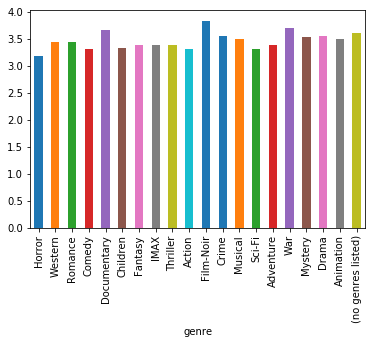

In [43]:
avg_rating_by_genre = genre_rating.groupBy("genre").avg("rating").toPandas()
avg_rating_by_genre.index = avg_rating_by_genre["genre"]
avg_rating_by_genre["avg(rating)"].plot.bar()

Enrich the movies dataset by computing the avg rating, rating count and number of unique user who has rated high.

In [44]:
movie_genre_stats = (genre_rating
 .withColumn("rating_avg", F.expr("avg(rating) over (partition by genre)"))
 .withColumn("rating_count", F.expr("count(*) over (partition by genre)"))
 .withColumn("rating_count", F.log("rating_count"))
 .withColumn("rating_std", F.expr("stddev(rating) over (partition by genre)"))
 .withColumn("unique_user_count_rank", F.expr("dense_rank() over (partition by genre order by userId)"))
 .withColumn("unique_user_count", F.expr("max(unique_user_count_rank) over (partition by genre)"))
 .withColumn("unique_user_count", F.log("unique_user_count"))
 .withColumn("high_rating", F.expr("sum(if(rating = 4 or rating = 5, 1, 0)) over (partition by genre)"))
 .withColumn("high_rating", F.expr("log(high_rating)"))
 .drop("unique_user_count_rank")
)
movie_genre_stats.limit(10).toPandas()

,movieId,title,genres,year,genre,userId,rating,timestamp,rating_avg,rating_count,rating_std,unique_user_count,high_rating
0,1339,Dracula (Bram Stoker's Dracula) (1992),"[Fantasy, Horror, Romance, Thriller]",1992,Horror,1,3,2009-12-14 08:22:05,3.181296,8.823206,1.151496,6.388561,7.954723
1,2455,"Fly, The (1986)","[Drama, Horror, Sci-Fi, Thriller]",1986,Horror,1,2,2009-12-14 08:21:53,3.181296,8.823206,1.151496,6.388561,7.954723
2,253,Interview with the Vampire: The Vampire Chroni...,"[Drama, Horror]",1994,Horror,2,4,1996-06-21 16:41:51,3.181296,8.823206,1.151496,6.388561,7.954723
3,273,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]",1994,Horror,2,4,1996-06-21 16:46:19,3.181296,8.823206,1.151496,6.388561,7.954723
4,382,Wolf (1994),"[Drama, Horror, Romance, Thriller]",1994,Horror,2,3,1996-06-21 16:52:45,3.181296,8.823206,1.151496,6.388561,7.954723
5,593,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",1991,Horror,2,3,1996-06-21 16:41:51,3.181296,8.823206,1.151496,6.388561,7.954723
6,593,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",1991,Horror,3,3,2011-03-01 01:07:20,3.181296,8.823206,1.151496,6.388561,7.954723
7,2513,Pet Sematary (1989),[Horror],1989,Horror,3,3,2011-02-28 08:26:29,3.181296,8.823206,1.151496,6.388561,7.954723
8,2762,"Sixth Sense, The (1999)","[Drama, Horror, Mystery]",1999,Horror,3,3,2011-03-01 01:10:57,3.181296,8.823206,1.151496,6.388561,7.954723
9,2841,Stir of Echoes (1999),"[Horror, Mystery, Thriller]",1999,Horror,3,4,2011-02-28 08:25:33,3.181296,8.823206,1.151496,6.388561,7.954723


Since each movie has multiple genres, it is a good idea to calculated IDF scores weighted by the individual measures like avg rating. To calculate IDF scores, we need to pass the data through a few steps => StringIndexer => Group by movie ID =>  Vectorizer => IDF transformer.

StringIndexer replaces the each string value of the genre with a corresponding index. 
Grouping aggregate genre level stat for each userId by packing them into a set column. Look at the below schem for for example.  
Vectorizes - Create a sparse vector that is required by TF-IDF.

In [45]:
from pyspark.ml.feature import StringIndexer, IDF
from pyspark.ml.pipeline import Pipeline

In [92]:
genre_indexer = StringIndexer(inputCol="genre", outputCol="genre_index")
stats_by_genre_indexed = genre_indexer.fit(movie_genre_stats).transform(movie_genre_stats)
stats_by_genre_indexed.limit(5).toPandas()

,movieId,title,genres,year,genre,userId,rating,timestamp,rating_avg,rating_count,rating_std,unique_user_count,high_rating,genre_index
0,1339,Dracula (Bram Stoker's Dracula) (1992),"[Fantasy, Horror, Romance, Thriller]",1992,Horror,1,3,2009-12-14 08:22:05,3.181296,8.823206,1.151496,6.388561,7.954723,11.0
1,2455,"Fly, The (1986)","[Drama, Horror, Sci-Fi, Thriller]",1986,Horror,1,2,2009-12-14 08:21:53,3.181296,8.823206,1.151496,6.388561,7.954723,11.0
2,253,Interview with the Vampire: The Vampire Chroni...,"[Drama, Horror]",1994,Horror,2,4,1996-06-21 16:41:51,3.181296,8.823206,1.151496,6.388561,7.954723,11.0
3,273,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]",1994,Horror,2,4,1996-06-21 16:46:19,3.181296,8.823206,1.151496,6.388561,7.954723,11.0
4,382,Wolf (1994),"[Drama, Horror, Romance, Thriller]",1994,Horror,2,3,1996-06-21 16:52:45,3.181296,8.823206,1.151496,6.388561,7.954723,11.0


In [47]:
stats_by_genre_structed = (stats_by_genre_indexed
    .withColumn("rating_count_by_genre", F.struct("genre_index", F.col("rating_count").alias("value")))
    .withColumn("rating_avg_by_genre", F.struct("genre_index", F.col("rating_avg").alias("value")))
    .withColumn("rating_std_by_genre", F.struct("genre_index", F.col("rating_std").alias("value")))
    .withColumn("unique_user_count_by_genre", F.struct("genre_index", F.col("unique_user_count").alias("value")))
    .withColumn("high_rating_by_genre", F.struct("genre_index", F.col("high_rating").alias("value")))
    )
stats_by_genre_structed.limit(5).toPandas()

,movieId,title,genres,year,genre,userId,rating,timestamp,rating_avg,rating_count,rating_std,unique_user_count,high_rating,genre_index,rating_count_by_genre,rating_avg_by_genre,rating_std_by_genre,unique_user_count_by_genre,high_rating_by_genre
0,1339,Dracula (Bram Stoker's Dracula) (1992),"[Fantasy, Horror, Romance, Thriller]",1992,Horror,1,3,2009-12-14 08:22:05,3.181296,8.823206,1.151496,6.388561,7.954723,11.0,"(11.0, 8.823206220552741)","(11.0, 3.1812960235640646)","(11.0, 1.1514958279439718)","(11.0, 6.38856140554563)","(11.0, 7.954723334497908)"
1,2455,"Fly, The (1986)","[Drama, Horror, Sci-Fi, Thriller]",1986,Horror,1,2,2009-12-14 08:21:53,3.181296,8.823206,1.151496,6.388561,7.954723,11.0,"(11.0, 8.823206220552741)","(11.0, 3.1812960235640646)","(11.0, 1.1514958279439718)","(11.0, 6.38856140554563)","(11.0, 7.954723334497908)"
2,253,Interview with the Vampire: The Vampire Chroni...,"[Drama, Horror]",1994,Horror,2,4,1996-06-21 16:41:51,3.181296,8.823206,1.151496,6.388561,7.954723,11.0,"(11.0, 8.823206220552741)","(11.0, 3.1812960235640646)","(11.0, 1.1514958279439718)","(11.0, 6.38856140554563)","(11.0, 7.954723334497908)"
3,273,Mary Shelley's Frankenstein (Frankenstein) (1994),"[Drama, Horror, Sci-Fi]",1994,Horror,2,4,1996-06-21 16:46:19,3.181296,8.823206,1.151496,6.388561,7.954723,11.0,"(11.0, 8.823206220552741)","(11.0, 3.1812960235640646)","(11.0, 1.1514958279439718)","(11.0, 6.38856140554563)","(11.0, 7.954723334497908)"
4,382,Wolf (1994),"[Drama, Horror, Romance, Thriller]",1994,Horror,2,3,1996-06-21 16:52:45,3.181296,8.823206,1.151496,6.388561,7.954723,11.0,"(11.0, 8.823206220552741)","(11.0, 3.1812960235640646)","(11.0, 1.1514958279439718)","(11.0, 6.38856140554563)","(11.0, 7.954723334497908)"


In [48]:
stats_by_genre_grouped_by_user = (stats_by_genre_structed
                                   .groupBy("userId")
                                   .agg(
                                     F.collect_set("rating_count_by_genre").alias("rating_count_by_genre")
                                   , F.collect_set("rating_avg_by_genre").alias("rating_avg_by_genre")
                                   , F.collect_set("rating_std_by_genre").alias("rating_std_by_genre")
                                   , F.collect_set("unique_user_count_by_genre").alias("unique_user_count_by_genre")
                                   , F.collect_set("high_rating_by_genre").alias("high_rating_by_genre")
                                  ))

stats_by_genre_grouped_by_user.limit(5).toPandas()

,userId,rating_count_by_genre,rating_avg_by_genre,rating_std_by_genre,unique_user_count_by_genre,high_rating_by_genre
0,12,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(12.0, 3.4912479740680715), (16.0, 3.44926778...","[(3.0, 1.0866794748049233), (0.0, 1.0486263341...","[(17.0, 5.552959584921617), (1.0, 6.5072777123...","[(12.0, 8.117312461601975), (5.0, 9.2159247502..."
1,18,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(11.0, 3.1812960235640646), (3.0, 3.384627575...","[(3.0, 1.0866794748049233), (2.0, 1.1159512760...","[(2.0, 6.508769136971682), (3.0, 6.50578406012...","[(10.0, 8.38548870041881), (5.0, 9.21592475027..."
2,38,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(13.0, 3.697313432835821), (16.0, 3.449267782...","[(3.0, 1.0866794748049233), (0.0, 1.0486263341...","[(17.0, 5.552959584921617), (1.0, 6.5072777123...","[(12.0, 8.117312461601975), (5.0, 9.2159247502..."
3,67,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(13.0, 3.697313432835821), (16.0, 3.449267782...","[(3.0, 1.0866794748049233), (0.0, 1.0486263341...","[(1.0, 6.507277712385012), (4.0, 6.50727771238...","[(12.0, 8.117312461601975), (5.0, 9.2159247502..."
4,70,"[(10.0, 8.939187601475613), (2.0, 10.205664071...","[(12.0, 3.4912479740680715), (2.0, 3.304590479...","[(3.0, 1.0866794748049233), (0.0, 1.0486263341...","[(1.0, 6.507277712385012), (4.0, 6.50727771238...","[(12.0, 8.117312461601975), (5.0, 9.2159247502..."


In [49]:
stats_by_genre_grouped_by_user.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- high_rating_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false

In [93]:
from pyspark.ml.linalg import SparseVector, VectorUDT

def to_vector(array_of_structs, size = 20):
    if array_of_structs is not None:
        array_of_structs = sorted(array_of_structs, key = lambda t: t.genre_index)
        indices = [s.genre_index for s in array_of_structs]
        values = [s.value for s in array_of_structs]
        return SparseVector(size, indices, values)
    return SparseVector(size, [], [])

spark.udf.register("to_vector", to_vector, VectorUDT())

stats_by_genre_grouped_by_user_vec = (stats_by_genre_grouped_by_user
            .withColumn("rating_count_by_genre_vec", F.expr("to_vector(rating_count_by_genre)"))
            .withColumn("rating_avg_by_genre_vec", F.expr("to_vector(rating_avg_by_genre)"))
            .withColumn("rating_std_by_genre_vec", F.expr("to_vector(rating_std_by_genre)"))
            .withColumn("unique_user_count_by_genre_vec", F.expr("to_vector(unique_user_count_by_genre)"))
            .withColumn("high_rating_by_genre_vec", F.expr("to_vector(high_rating_by_genre)"))
)
stats_by_genre_grouped_by_user_vec.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- high_rating_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false

In [53]:
from pyspark.ml.feature import IDF
from pyspark.ml.pipeline import Pipeline

In [55]:
pipe = Pipeline(stages = [
    IDF(inputCol="rating_count_by_genre_vec", outputCol="rating_count_by_genre_idf"),
    IDF(inputCol="rating_avg_by_genre_vec", outputCol="rating_avg_by_genre_idf"),
    IDF(inputCol= "rating_std_by_genre_vec", outputCol="rating_std_by_genre_idf"),
    IDF(inputCol="unique_user_count_by_genre_vec", outputCol="unique_user_by_genre_idf"),
    IDF(inputCol="high_rating_by_genre_vec", outputCol="high_rating_by_genre_idf")
])

user_profile_idf = pipe.fit(stats_by_genre_grouped_by_user_vec).transform(stats_by_genre_grouped_by_user_vec)

In [56]:
user_profile_idf.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- high_rating_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false

In [57]:
enriched = (ratings
            .join(movies, on = "movieId")
            .join(user_profile_idf, on = "userId")
            .withColumn("rating", F.expr("cast(rating * 2 as int)"))
#            .withColumn("year", F.regexp_extract("title", r"\d+", 1))
#            .withColumn("age", F.expr("year(from_unixtime(timestamp)) - year"))
           )
enriched.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |

In [58]:
from pyspark.ml.feature import VectorAssembler

In [59]:
vector_assembler = VectorAssembler(outputCol="features", inputCols=[
                                        'rating_count_by_genre_idf',
                                        'rating_avg_by_genre_idf',
                                        'rating_std_by_genre_idf',
                                        'unique_user_by_genre_idf',
                                        'high_rating_by_genre_idf'])
enriched_vec = vector_assembler.transform(enriched)

In [60]:
df_train, df_test = enriched_vec.randomSplit([0.7, 0.3], 1)
cache_df(df_train, "df_train")

In [61]:
df_train.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- rating_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_avg_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- rating_std_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |    |    |-- value: double (nullable = true)
 |-- unique_user_count_by_genre: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- genre_index: double (nullable = false)
 |

In [62]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [154]:
lr = LogisticRegression(family="multinomial", maxIter=10, regParam=0.0
                    , elasticNetParam=0.8, featuresCol="features", labelCol="rating")

lr_model= lr.fit(df_train)
                
predictions = lr_model.transform(df_test)

evaluator = MulticlassClassificationEvaluator(
      labelCol="rating"
    , predictionCol="prediction"
    , metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test accuracy = %g " % (accuracy))

Test accuracy = 0.361758 


In [64]:
df_train.select("rating").distinct().collect()

[Row(rating=10),
 Row(rating=2),
 Row(rating=6),
 Row(rating=4),
 Row(rating=8),
 Row(rating=0)]